In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
from keras import applications
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, Model 
from keras.layers import Dropout, Flatten, Dense, MaxPooling2D, Conv2D, InputLayer, Activation
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras import backend as K

from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.manifold import TSNE

import h5py
import json
import os
import shutil
import glob
import zipfile
import numpy as np

CLASSES = ['sandwich','sushi']
img_width, img_height = 128, 128
batch_size = 32
patience = 20 # how many epochs are we willing to wait before stopping the training early?

data_dir = "sushi_or_sandwich"
train_dir = "{}/train".format(data_dir)
test_dir = "{}/test".format(data_dir)

Using TensorFlow backend.
/usr/local/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


## Download the training photos if not already available

In [3]:
if not os.path.isfile('sushi_or_sandwich_photos.zip'):
  !wget http://research.us-east-1.s3.amazonaws.com/public/sushi_or_sandwich_photos.zip       

## Train - Test split

In [4]:
# Extract if not already extracted
if not os.path.isdir(data_dir):
    zip_ref = zipfile.ZipFile('sushi_or_sandwich_photos.zip', 'r')
    zip_ref.extractall('./')
    zip_ref.close() 

    # Delete existing folders
    for _class in CLASSES:
        for _dir in [train_dir, test_dir]:
            this = '{}/{}'.format(_dir,_class)
            print (this)
            if os.path.isdir(this):
                shutil.rmtree(this)
            os.makedirs(this)

    # Allocate images according to new train, test split and order permutation
    for _class in CLASSES:
        files = glob.glob('{}/{}/*.jpg'.format(data_dir,_class))
        indices = np.random.permutation(len(files))
        train_test_split = int(len(files)*0.8)
        for i,ix in enumerate(indices):
            src = files[ix]
            dest = '{}/{}/{}'.format(train_dir if i < train_test_split else test_dir,_class,files[ix].split('/')[-1])
            shutil.copyfile(src, dest)

## Create train and test data generators with data augmentation

In [5]:
datagen = ImageDataGenerator(
    rescale = 1./255,
    horizontal_flip = True,
    shear_range=0.2,
    zoom_range = 0.2,
    rotation_range=30)

train_generator = datagen.flow_from_directory(
    train_dir,
    color_mode = 'rgb',
    target_size = (img_height, img_width),
    batch_size = batch_size, 
    class_mode = "binary",
    shuffle = True,
)

test_generator = datagen.flow_from_directory(
    test_dir,
    color_mode = 'rgb',    
    target_size = (img_height, img_width),
    batch_size = batch_size,     
    class_mode = "binary",
    shuffle = True,
)

Found 642 images belonging to 2 classes.
Found 162 images belonging to 2 classes.


## Inspect a batch of training images

{'sandwich': 0, 'sushi': 1}


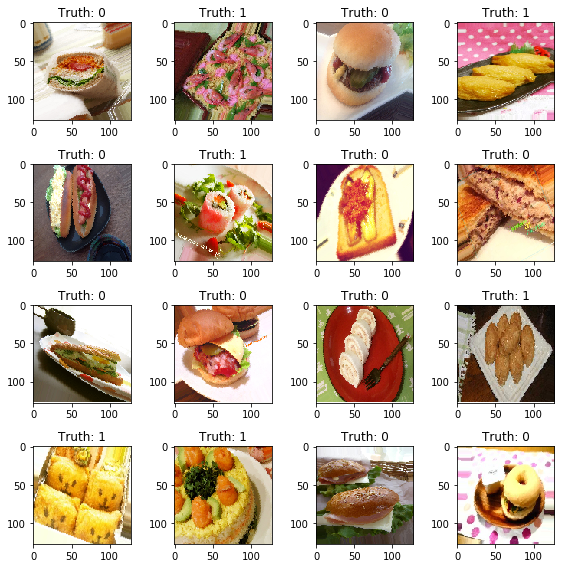

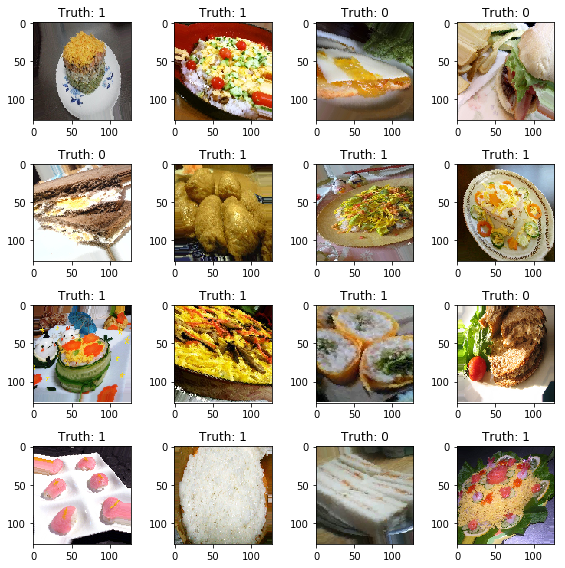

In [6]:
print(train_generator.class_indices)

images,labels=train_generator[0]

for ix,(im,l) in enumerate(zip(images,labels)):
    if ix%16 == 0:
        plt.figure(figsize=(8,8))
    plt.subplot(4,4,ix%16+1)
    plt.imshow(im)
    plt.title('Truth: {:0.0f}'.format(l))
    if (ix+1)%16 == 0:
        plt.tight_layout()

# First, let's try a CNN model

In [7]:
model = Sequential()

# inputlayer
model.add(InputLayer(input_shape=(img_width, img_height, 3)))

# conv1
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# conv2
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# conv3
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())

# fc1
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.5))

# fc2
model.add(Dense(1))
model.add(Activation('sigmoid'))

# output
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 128, 128, 3)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 126, 126, 32)      896       
_________________________________________________________________
activation_1 (Activation)    (None, 126, 126, 32)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 61, 61, 32)        9248      
_________________________________________________________________
activation_2 (Activation)    (None, 61, 61, 32)        0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 30, 30, 32)        0         
__________

## Now, run the model

In [8]:
nb_epochs = 50

# train the model
model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

if not os.path.isfile('model.h5'):

    # Save the model according to the conditions  
    checkpoint = ModelCheckpoint("checkpoint.h5", monitor='val_acc', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
    early = EarlyStopping(monitor='val_acc', min_delta=0, patience=patience, verbose=1, mode='auto')

    # Train the model 
    history = model.fit_generator(
        train_generator,
        steps_per_epoch = len(train_generator),
        epochs = nb_epochs,
        validation_data = test_generator,
        validation_steps = len(test_generator),
        callbacks = [checkpoint, early])

    # Dump training history to file
    with open('history.json','w') as f:
        json.dump(history.history,f,indent=True)

    # Save the model weights
    model.save_weights('model.h5')
else:
    model.load_weights('model.h5')

```
Epoch 1/50
20/21 [===========================>..] - ETA: 1s - loss: 0.8137 - acc: 0.5203Epoch 00001: val_acc improved from -inf to 0.50000, saving model to checkpoint.h5
21/21 [==============================] - 57s 3s/step - loss: 0.8073 - acc: 0.5422 - val_loss: 0.6923 - val_acc: 0.5000
Epoch 2/50
20/21 [===========================>..] - ETA: 1s - loss: 0.6945 - acc: 0.5047Epoch 00002: val_acc did not improve
21/21 [==============================] - 44s 2s/step - loss: 0.6936 - acc: 0.5273 - val_loss: 0.7140 - val_acc: 0.5000
Epoch 3/50
20/21 [===========================>..] - ETA: 1s - loss: 0.7022 - acc: 0.5813Epoch 00003: val_acc improved from 0.50000 to 0.61111, saving model to checkpoint.h5
21/21 [==============================] - 40s 2s/step - loss: 0.7034 - acc: 0.5675 - val_loss: 0.6707 - val_acc: 0.6111
Epoch 4/50
20/21 [===========================>..] - ETA: 1s - loss: 0.6880 - acc: 0.5703Epoch 00004: val_acc improved from 0.61111 to 0.70988, saving model to checkpoint.h5
21/21 [==============================] - 37s 2s/step - loss: 0.6832 - acc: 0.5761 - val_loss: 0.6074 - val_acc: 0.7099
Epoch 5/50
20/21 [===========================>..] - ETA: 2s - loss: 0.6903 - acc: 0.5828Epoch 00005: val_acc did not improve
21/21 [==============================] - 55s 3s/step - loss: 0.6882 - acc: 0.5865 - val_loss: 0.6485 - val_acc: 0.5123
Epoch 6/50
20/21 [===========================>..] - ETA: 1s - loss: 0.6663 - acc: 0.5922Epoch 00006: val_acc did not improve
21/21 [==============================] - 37s 2s/step - loss: 0.6616 - acc: 0.6014 - val_loss: 0.6073 - val_acc: 0.7099
Epoch 7/50
20/21 [===========================>..] - ETA: 1s - loss: 0.6679 - acc: 0.6422Epoch 00007: val_acc did not improve
21/21 [==============================] - 35s 2s/step - loss: 0.6668 - acc: 0.6436 - val_loss: 0.6047 - val_acc: 0.7099
Epoch 8/50
20/21 [===========================>..] - ETA: 1s - loss: 0.6436 - acc: 0.6359Epoch 00008: val_acc did not improve
21/21 [==============================] - 40s 2s/step - loss: 0.6507 - acc: 0.6297 - val_loss: 0.6641 - val_acc: 0.5556
Epoch 9/50
20/21 [===========================>..] - ETA: 1s - loss: 0.6326 - acc: 0.6531Epoch 00009: val_acc improved from 0.70988 to 0.72840, saving model to checkpoint.h5
21/21 [==============================] - 36s 2s/step - loss: 0.6344 - acc: 0.6481 - val_loss: 0.6192 - val_acc: 0.7284
Epoch 10/50
20/21 [===========================>..] - ETA: 1s - loss: 0.6322 - acc: 0.6359Epoch 00010: val_acc did not improve
21/21 [==============================] - 33s 2s/step - loss: 0.6329 - acc: 0.6357 - val_loss: 0.6229 - val_acc: 0.5926
Epoch 11/50
20/21 [===========================>..] - ETA: 1s - loss: 0.6279 - acc: 0.6406Epoch 00011: val_acc did not improve
21/21 [==============================] - 38s 2s/step - loss: 0.6289 - acc: 0.6402 - val_loss: 0.7447 - val_acc: 0.5679
Epoch 12/50
20/21 [===========================>..] - ETA: 1s - loss: 0.6179 - acc: 0.6859Epoch 00012: val_acc did not improve
21/21 [==============================] - 37s 2s/step - loss: 0.6167 - acc: 0.6839 - val_loss: 0.5686 - val_acc: 0.7037
Epoch 13/50
20/21 [===========================>..] - ETA: 1s - loss: 0.6274 - acc: 0.6641Epoch 00013: val_acc did not improve
21/21 [==============================] - 33s 2s/step - loss: 0.6259 - acc: 0.6655 - val_loss: 0.6159 - val_acc: 0.6420
Epoch 14/50
20/21 [===========================>..] - ETA: 1s - loss: 0.6236 - acc: 0.6375Epoch 00014: val_acc did not improve
21/21 [==============================] - 34s 2s/step - loss: 0.6321 - acc: 0.6342 - val_loss: 0.6136 - val_acc: 0.6605
Epoch 15/50
20/21 [===========================>..] - ETA: 1s - loss: 0.6240 - acc: 0.6484Epoch 00015: val_acc did not improve
21/21 [==============================] - 34s 2s/step - loss: 0.6180 - acc: 0.6585 - val_loss: 0.5735 - val_acc: 0.7222
Epoch 16/50
20/21 [===========================>..] - ETA: 1s - loss: 0.5850 - acc: 0.6625Epoch 00016: val_acc did not improve
21/21 [==============================] - 38s 2s/step - loss: 0.5833 - acc: 0.6700 - val_loss: 0.5739 - val_acc: 0.6914
Epoch 17/50
20/21 [===========================>..] - ETA: 1s - loss: 0.6217 - acc: 0.6750Epoch 00017: val_acc did not improve
21/21 [==============================] - 35s 2s/step - loss: 0.6165 - acc: 0.6849 - val_loss: 0.5907 - val_acc: 0.7099
Epoch 18/50
20/21 [===========================>..] - ETA: 1s - loss: 0.6193 - acc: 0.7000Epoch 00018: val_acc did not improve
21/21 [==============================] - 35s 2s/step - loss: 0.6168 - acc: 0.6968 - val_loss: 0.5955 - val_acc: 0.7037
Epoch 19/50
20/21 [===========================>..] - ETA: 1s - loss: 0.5580 - acc: 0.7250Epoch 00019: val_acc improved from 0.72840 to 0.74691, saving model to checkpoint.h5
21/21 [==============================] - 35s 2s/step - loss: 0.5585 - acc: 0.7211 - val_loss: 0.5633 - val_acc: 0.7469
Epoch 20/50
20/21 [===========================>..] - ETA: 1s - loss: 0.6114 - acc: 0.6703Epoch 00020: val_acc did not improve
21/21 [==============================] - 35s 2s/step - loss: 0.6084 - acc: 0.6755 - val_loss: 0.5951 - val_acc: 0.6790
Epoch 21/50
20/21 [===========================>..] - ETA: 1s - loss: 0.5552 - acc: 0.7203Epoch 00021: val_acc did not improve
21/21 [==============================] - 35s 2s/step - loss: 0.5579 - acc: 0.7167 - val_loss: 0.5780 - val_acc: 0.6975
Epoch 22/50
20/21 [===========================>..] - ETA: 1s - loss: 0.5493 - acc: 0.7203Epoch 00022: val_acc did not improve
21/21 [==============================] - 35s 2s/step - loss: 0.5435 - acc: 0.7241 - val_loss: 0.5610 - val_acc: 0.7222
Epoch 23/50
20/21 [===========================>..] - ETA: 1s - loss: 0.5754 - acc: 0.7344Epoch 00023: val_acc did not improve
21/21 [==============================] - 35s 2s/step - loss: 0.5763 - acc: 0.7286 - val_loss: 0.5676 - val_acc: 0.7407
Epoch 24/50
20/21 [===========================>..] - ETA: 1s - loss: 0.5235 - acc: 0.7203Epoch 00024: val_acc did not improve
21/21 [==============================] - 35s 2s/step - loss: 0.5292 - acc: 0.7167 - val_loss: 0.5641 - val_acc: 0.7160
Epoch 25/50
20/21 [===========================>..] - ETA: 1s - loss: 0.5372 - acc: 0.7172Epoch 00025: val_acc did not improve
21/21 [==============================] - 40s 2s/step - loss: 0.5416 - acc: 0.7167 - val_loss: 0.5905 - val_acc: 0.7222
Epoch 26/50
20/21 [===========================>..] - ETA: 1s - loss: 0.5408 - acc: 0.7234Epoch 00026: val_acc did not improve
21/21 [==============================] - 37s 2s/step - loss: 0.5420 - acc: 0.7226 - val_loss: 0.5925 - val_acc: 0.6975
Epoch 27/50
20/21 [===========================>..] - ETA: 1s - loss: 0.5609 - acc: 0.6953Epoch 00027: val_acc did not improve
21/21 [==============================] - 33s 2s/step - loss: 0.5651 - acc: 0.6919 - val_loss: 0.5866 - val_acc: 0.7222
Epoch 28/50
20/21 [===========================>..] - ETA: 1s - loss: 0.5481 - acc: 0.7188Epoch 00028: val_acc did not improve
21/21 [==============================] - 34s 2s/step - loss: 0.5446 - acc: 0.7252 - val_loss: 0.5714 - val_acc: 0.7160
Epoch 29/50
20/21 [===========================>..] - ETA: 1s - loss: 0.5435 - acc: 0.7375Epoch 00029: val_acc did not improve
21/21 [==============================] - 36s 2s/step - loss: 0.5580 - acc: 0.7316 - val_loss: 0.6432 - val_acc: 0.6914
Epoch 30/50
20/21 [===========================>..] - ETA: 1s - loss: 0.5224 - acc: 0.7484Epoch 00030: val_acc did not improve
21/21 [==============================] - 35s 2s/step - loss: 0.5288 - acc: 0.7450 - val_loss: 0.6107 - val_acc: 0.6543
Epoch 31/50
20/21 [===========================>..] - ETA: 1s - loss: 0.5093 - acc: 0.7609Epoch 00031: val_acc did not improve
21/21 [==============================] - 39s 2s/step - loss: 0.5114 - acc: 0.7614 - val_loss: 0.5569 - val_acc: 0.7469
Epoch 32/50
20/21 [===========================>..] - ETA: 1s - loss: 0.5454 - acc: 0.7594Epoch 00032: val_acc did not improve
21/21 [==============================] - 34s 2s/step - loss: 0.5475 - acc: 0.7525 - val_loss: 0.5781 - val_acc: 0.6914
Epoch 33/50
20/21 [===========================>..] - ETA: 1s - loss: 0.5286 - acc: 0.7375Epoch 00033: val_acc did not improve
21/21 [==============================] - 36s 2s/step - loss: 0.5234 - acc: 0.7435 - val_loss: 0.5959 - val_acc: 0.6914
Epoch 34/50
20/21 [===========================>..] - ETA: 1s - loss: 0.5048 - acc: 0.7406Epoch 00034: val_acc did not improve
21/21 [==============================] - 36s 2s/step - loss: 0.5068 - acc: 0.7386 - val_loss: 0.5741 - val_acc: 0.7160
Epoch 35/50
20/21 [===========================>..] - ETA: 1s - loss: 0.5510 - acc: 0.7094Epoch 00035: val_acc did not improve
21/21 [==============================] - 37s 2s/step - loss: 0.5490 - acc: 0.7088 - val_loss: 0.6437 - val_acc: 0.6358
Epoch 36/50
20/21 [===========================>..] - ETA: 1s - loss: 0.5099 - acc: 0.7516Epoch 00036: val_acc did not improve
21/21 [==============================] - 35s 2s/step - loss: 0.5063 - acc: 0.7550 - val_loss: 0.5907 - val_acc: 0.7407
Epoch 37/50
20/21 [===========================>..] - ETA: 1s - loss: 0.4925 - acc: 0.7578Epoch 00037: val_acc did not improve
21/21 [==============================] - 40s 2s/step - loss: 0.5044 - acc: 0.7550 - val_loss: 0.6814 - val_acc: 0.6173
Epoch 38/50
20/21 [===========================>..] - ETA: 1s - loss: 0.4970 - acc: 0.7656Epoch 00038: val_acc did not improve
21/21 [==============================] - 34s 2s/step - loss: 0.4975 - acc: 0.7674 - val_loss: 0.5934 - val_acc: 0.7346
Epoch 39/50
20/21 [===========================>..] - ETA: 1s - loss: 0.5072 - acc: 0.7562Epoch 00039: val_acc did not improve
21/21 [==============================] - 39s 2s/step - loss: 0.5059 - acc: 0.7595 - val_loss: 0.7615 - val_acc: 0.7222
Epoch 00039: early stopping
```

## How did the model perform?

70.28% mean accuracy in the final 20 epochs.


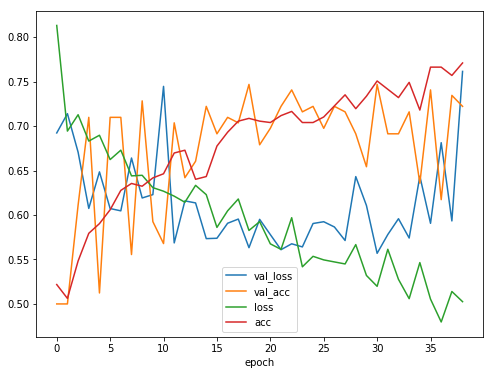

In [9]:
with open('history.json','r') as f:
    h = json.load(f)

plt.figure(figsize=(8,6))
for k,v in h.items():
    plt.plot(v,label=k)
plt.legend()
plt.xlabel('epoch')

print('{:0.2f}% mean accuracy in the final {} epochs.'.format(np.mean(h['val_acc'][-patience:])*100, patience))

## Let's look at the ROC curve

In [10]:
# Helper function to plot a roc curve and calculated AUC using model and generator
def plot_roc_curve(_model, _generator):
    y_true = list()
    y_pred = list()
    for i in range(len(_generator)):
        _images, _labels = _generator[i]
        y_true.append(_labels)
        y_pred.append(_model.predict(_images))
    y_true = np.hstack(y_true)
    y_pred = np.vstack(y_pred)    
    fpr, tpr, thresholds = roc_curve(y_true, y_pred)
    roc_auc = roc_auc_score(y_true,y_pred)
    plt.figure(figsize=(6,6))
    plt.axis('equal')
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.show()

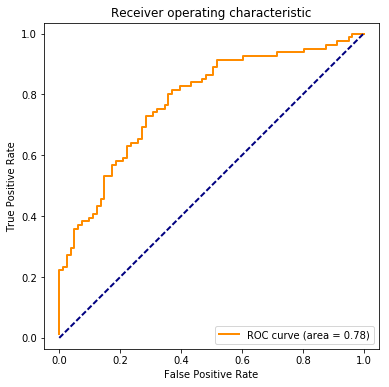

In [11]:
plot_roc_curve(model,test_generator)    

# Can we do better using [MobileNet](https://arxiv.org/pdf/1704.04861.pdf) weights trained on Imagenet dataset?

In [12]:
# Get the weights of all except the final layer
if not os.path.isfile('mobilenet_1_0_128_tf_no_top.h5'):
    !wget https://github.com/fchollet/deep-learning-models/releases/download/v0.6/mobilenet_1_0_128_tf_no_top.h5
model_bottleneck = applications.MobileNet(weights='mobilenet_1_0_128_tf_no_top.h5',include_top=False,input_shape=(img_height,img_width,3))

# Disable training in all layers as we do not want to touch the weights
for layer in model_bottleneck.layers:
    layer.trainable = False

In [13]:
model_bottleneck.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 128, 128, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 64, 64, 32)        864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 64, 64, 32)        128       
_________________________________________________________________
conv1_relu (Activation)      (None, 64, 64, 32)        0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 64, 64, 32)        288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 64, 64, 32)        128       
_________________________________________________________________
conv_dw_1_relu (Activation)  (None, 64, 64, 32)        0         
__________

In [14]:
if not os.path.isfile('features-bottleneck.h5'):
    train_bottleneck_generator = datagen.flow_from_directory(
        train_dir,
        color_mode = 'rgb',
        target_size = (img_height, img_width),
        batch_size = batch_size, 
        class_mode = None,
        shuffle = False,
    )
    test_bottleneck_generator = datagen.flow_from_directory(
        test_dir,
        color_mode = 'rgb',    
        target_size = (img_height, img_width),
        batch_size = batch_size,     
        class_mode = None,
        shuffle = False,
    )    
    train_bottleneck = model_bottleneck.predict_generator(train_bottleneck_generator,verbose=1)
    test_bottleneck = model_bottleneck.predict_generator(test_bottleneck_generator,verbose=1) 
    train_labels = train_generator.classes
    test_labels = test_generator.classes
    with h5py.File('features-bottleneck.h5','w') as f:
        f['train/bottleneck'] = train_bottleneck
        f['test/bottleneck'] = test_bottleneck
        f['train/labels'] = train_labels
        f['test/labels'] = test_labels
        
with h5py.File('features-bottleneck.h5','r') as f:
    train_bottleneck = np.array(f['train/bottleneck'])
    test_bottleneck = np.array(f['test/bottleneck'])
    train_labels = np.array(f['train/labels'])
    test_labels = np.array(f['test/labels'])    

## Train the second-to-last layer weights against the binary categories

In [15]:
model_top = Sequential()
model_top.add(Flatten(input_shape=train_bottleneck.shape[1:]))
model_top.add(Dense(128))
model_top.add(Activation('relu'))
model_top.add(Dropout(0.5))
model_top.add(Dense(1))
model_top.add(Activation('sigmoid'))

model_top.summary()

model_top.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_2 (Flatten)          (None, 16384)             0         
_________________________________________________________________
dense_3 (Dense)              (None, 128)               2097280   
_________________________________________________________________
activation_6 (Activation)    (None, 128)               0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 129       
_________________________________________________________________
activation_7 (Activation)    (None, 1)                 0         
Total params: 2,097,409
Trainable params: 2,097,409
Non-trainable params: 0
_________________________________________________________________


In [16]:
nb_epoch=50

if not os.path.isfile('model-top.h5'):
    checkpoint = ModelCheckpoint("checkpoint-top.h5", monitor='val_acc', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
    early = EarlyStopping(monitor='val_acc', min_delta=0, patience=patience, verbose=1, mode='auto')

    history_top = model_top.fit(
        train_bottleneck,
        train_labels,
        epochs=nb_epoch,
        batch_size=batch_size,
        validation_data=(test_bottleneck, test_labels),
        callbacks=[checkpoint,early])
    
    # Dump training history to file
    with open('history-top.json','w') as f:
        json.dump(history_top.history,f,indent=True)

    # Save the model weights
    model_top.save_weights('model-top.h5')
else:
    model_top.load_weights('model-top.h5')    

```
Train on 642 samples, validate on 162 samples
Epoch 1/50
640/642 [============================>.] - ETA: 0s - loss: 4.1892 - acc: 0.6500Epoch 00001: val_acc improved from -inf to 0.78395, saving model to checkpoint-top.h5
642/642 [==============================] - 2s 3ms/step - loss: 4.1761 - acc: 0.6511 - val_loss: 2.2997 - val_acc: 0.7840
Epoch 2/50
640/642 [============================>.] - ETA: 0s - loss: 1.6569 - acc: 0.8234Epoch 00002: val_acc did not improve
642/642 [==============================] - 1s 2ms/step - loss: 1.6554 - acc: 0.8224 - val_loss: 2.6219 - val_acc: 0.7531
Epoch 3/50
608/642 [===========================>..] - ETA: 0s - loss: 0.7319 - acc: 0.8832Epoch 00003: val_acc improved from 0.78395 to 0.85185, saving model to checkpoint-top.h5
642/642 [==============================] - 1s 2ms/step - loss: 0.7218 - acc: 0.8832 - val_loss: 0.9028 - val_acc: 0.8519
Epoch 4/50
608/642 [===========================>..] - ETA: 0s - loss: 0.3900 - acc: 0.9128Epoch 00004: val_acc did not improve
642/642 [==============================] - 1s 2ms/step - loss: 0.3811 - acc: 0.9143 - val_loss: 0.7768 - val_acc: 0.7840
Epoch 5/50
640/642 [============================>.] - ETA: 0s - loss: 0.1947 - acc: 0.9547Epoch 00005: val_acc did not improve
642/642 [==============================] - 1s 2ms/step - loss: 0.1940 - acc: 0.9548 - val_loss: 0.7928 - val_acc: 0.8025
Epoch 6/50
608/642 [===========================>..] - ETA: 0s - loss: 0.2522 - acc: 0.9375Epoch 00006: val_acc did not improve
642/642 [==============================] - 1s 2ms/step - loss: 0.2687 - acc: 0.9361 - val_loss: 1.5584 - val_acc: 0.7840
Epoch 7/50
608/642 [===========================>..] - ETA: 0s - loss: 0.1699 - acc: 0.9474Epoch 00007: val_acc improved from 0.85185 to 0.86420, saving model to checkpoint-top.h5
642/642 [==============================] - 1s 2ms/step - loss: 0.1685 - acc: 0.9486 - val_loss: 0.8387 - val_acc: 0.8642
Epoch 8/50
640/642 [============================>.] - ETA: 0s - loss: 0.2300 - acc: 0.9500Epoch 00008: val_acc did not improve
642/642 [==============================] - 1s 2ms/step - loss: 0.2293 - acc: 0.9502 - val_loss: 1.2448 - val_acc: 0.8457
Epoch 9/50
640/642 [============================>.] - ETA: 0s - loss: 0.1556 - acc: 0.9594Epoch 00009: val_acc did not improve
642/642 [==============================] - 1s 2ms/step - loss: 0.1551 - acc: 0.9595 - val_loss: 1.1696 - val_acc: 0.8333
Epoch 10/50
640/642 [============================>.] - ETA: 0s - loss: 0.0817 - acc: 0.9750Epoch 00010: val_acc did not improve
642/642 [==============================] - 1s 2ms/step - loss: 0.0815 - acc: 0.9751 - val_loss: 1.1649 - val_acc: 0.8642
Epoch 11/50
640/642 [============================>.] - ETA: 0s - loss: 0.0540 - acc: 0.9859Epoch 00011: val_acc did not improve
642/642 [==============================] - 1s 2ms/step - loss: 0.0538 - acc: 0.9860 - val_loss: 1.2196 - val_acc: 0.8333
Epoch 12/50
608/642 [===========================>..] - ETA: 0s - loss: 0.0399 - acc: 0.9901Epoch 00012: val_acc did not improve
642/642 [==============================] - 1s 2ms/step - loss: 0.0463 - acc: 0.9875 - val_loss: 1.9146 - val_acc: 0.7901
Epoch 13/50
608/642 [===========================>..] - ETA: 0s - loss: 0.0756 - acc: 0.9852Epoch 00013: val_acc did not improve
642/642 [==============================] - 1s 2ms/step - loss: 0.0721 - acc: 0.9860 - val_loss: 1.5881 - val_acc: 0.8025
Epoch 14/50
640/642 [============================>.] - ETA: 0s - loss: 0.1852 - acc: 0.9594Epoch 00014: val_acc did not improve
642/642 [==============================] - 1s 2ms/step - loss: 0.1846 - acc: 0.9595 - val_loss: 1.1684 - val_acc: 0.8457
Epoch 15/50
640/642 [============================>.] - ETA: 0s - loss: 0.0297 - acc: 0.9922Epoch 00015: val_acc did not improve
642/642 [==============================] - 1s 2ms/step - loss: 0.0296 - acc: 0.9922 - val_loss: 1.1740 - val_acc: 0.8642
Epoch 16/50
608/642 [===========================>..] - ETA: 0s - loss: 0.0073 - acc: 0.9967  Epoch 00016: val_acc improved from 0.86420 to 0.87037, saving model to checkpoint-top.h5
642/642 [==============================] - 1s 2ms/step - loss: 0.0082 - acc: 0.9953 - val_loss: 1.1903 - val_acc: 0.8704
Epoch 17/50
640/642 [============================>.] - ETA: 0s - loss: 0.0235 - acc: 0.9938Epoch 00017: val_acc did not improve
642/642 [==============================] - 1s 2ms/step - loss: 0.0234 - acc: 0.9938 - val_loss: 1.2193 - val_acc: 0.8519
Epoch 18/50
640/642 [============================>.] - ETA: 0s - loss: 0.0566 - acc: 0.9922Epoch 00018: val_acc did not improve
642/642 [==============================] - 1s 2ms/step - loss: 0.0564 - acc: 0.9922 - val_loss: 1.4382 - val_acc: 0.8704
Epoch 19/50
640/642 [============================>.] - ETA: 0s - loss: 0.0516 - acc: 0.9859Epoch 00019: val_acc did not improve
642/642 [==============================] - 1s 2ms/step - loss: 0.0515 - acc: 0.9860 - val_loss: 1.4290 - val_acc: 0.8519
Epoch 20/50
640/642 [============================>.] - ETA: 0s - loss: 0.0329 - acc: 0.9953Epoch 00020: val_acc did not improve
642/642 [==============================] - 1s 2ms/step - loss: 0.0328 - acc: 0.9953 - val_loss: 1.5555 - val_acc: 0.8272
Epoch 21/50
640/642 [============================>.] - ETA: 0s - loss: 0.0318 - acc: 0.9859Epoch 00021: val_acc did not improve
642/642 [==============================] - 1s 2ms/step - loss: 0.0329 - acc: 0.9844 - val_loss: 1.3340 - val_acc: 0.8519
Epoch 22/50
640/642 [============================>.] - ETA: 0s - loss: 0.0289 - acc: 0.9906Epoch 00022: val_acc did not improve
642/642 [==============================] - 1s 2ms/step - loss: 0.0288 - acc: 0.9907 - val_loss: 1.2460 - val_acc: 0.8580
Epoch 23/50
640/642 [============================>.] - ETA: 0s - loss: 0.0058 - acc: 0.9984  Epoch 00023: val_acc did not improve
642/642 [==============================] - 1s 2ms/step - loss: 0.0058 - acc: 0.9984 - val_loss: 1.1848 - val_acc: 0.8272
Epoch 24/50
640/642 [============================>.] - ETA: 0s - loss: 0.0119 - acc: 0.9953Epoch 00024: val_acc did not improve
642/642 [==============================] - 1s 2ms/step - loss: 0.0119 - acc: 0.9953 - val_loss: 1.3655 - val_acc: 0.8395
Epoch 25/50
640/642 [============================>.] - ETA: 0s - loss: 0.0104 - acc: 0.9969   Epoch 00025: val_acc did not improve
642/642 [==============================] - 1s 2ms/step - loss: 0.0104 - acc: 0.9969 - val_loss: 1.4484 - val_acc: 0.8272
Epoch 26/50
640/642 [============================>.] - ETA: 0s - loss: 0.0566 - acc: 0.9875Epoch 00026: val_acc did not improve
642/642 [==============================] - 1s 2ms/step - loss: 0.0564 - acc: 0.9875 - val_loss: 1.5448 - val_acc: 0.8395
Epoch 27/50
640/642 [============================>.] - ETA: 0s - loss: 0.0078 - acc: 0.9969Epoch 00027: val_acc did not improve
642/642 [==============================] - 1s 2ms/step - loss: 0.0077 - acc: 0.9969 - val_loss: 1.6761 - val_acc: 0.8395
Epoch 28/50
640/642 [============================>.] - ETA: 0s - loss: 0.0327 - acc: 0.9953Epoch 00028: val_acc did not improve
642/642 [==============================] - 1s 2ms/step - loss: 0.0326 - acc: 0.9953 - val_loss: 1.2530 - val_acc: 0.8704
Epoch 29/50
640/642 [============================>.] - ETA: 0s - loss: 0.0118 - acc: 0.9938Epoch 00029: val_acc improved from 0.87037 to 0.87654, saving model to checkpoint-top.h5
642/642 [==============================] - 1s 2ms/step - loss: 0.0118 - acc: 0.9938 - val_loss: 1.3272 - val_acc: 0.8765
Epoch 30/50
640/642 [============================>.] - ETA: 0s - loss: 0.0122 - acc: 0.9984Epoch 00030: val_acc did not improve
642/642 [==============================] - 1s 2ms/step - loss: 0.0121 - acc: 0.9984 - val_loss: 1.4350 - val_acc: 0.8519
Epoch 31/50
640/642 [============================>.] - ETA: 0s - loss: 0.0207 - acc: 0.9969   Epoch 00031: val_acc did not improve
642/642 [==============================] - 1s 2ms/step - loss: 0.0207 - acc: 0.9969 - val_loss: 1.4072 - val_acc: 0.8642
Epoch 32/50
640/642 [============================>.] - ETA: 0s - loss: 0.0122 - acc: 0.9938Epoch 00032: val_acc did not improve
642/642 [==============================] - 2s 2ms/step - loss: 0.0121 - acc: 0.9938 - val_loss: 1.5189 - val_acc: 0.8704
Epoch 33/50
640/642 [============================>.] - ETA: 0s - loss: 0.0065 - acc: 0.9984    Epoch 00033: val_acc did not improve
642/642 [==============================] - 2s 2ms/step - loss: 0.0065 - acc: 0.9984 - val_loss: 1.6104 - val_acc: 0.8580
Epoch 34/50
608/642 [===========================>..] - ETA: 0s - loss: 7.6629e-04 - acc: 1.0000Epoch 00034: val_acc did not improve
642/642 [==============================] - 1s 2ms/step - loss: 7.3301e-04 - acc: 1.0000 - val_loss: 1.4264 - val_acc: 0.8642
Epoch 35/50
640/642 [============================>.] - ETA: 0s - loss: 0.0063 - acc: 0.9969Epoch 00035: val_acc did not improve
642/642 [==============================] - 1s 2ms/step - loss: 0.0063 - acc: 0.9969 - val_loss: 1.6196 - val_acc: 0.8580
Epoch 36/50
640/642 [============================>.] - ETA: 0s - loss: 0.0022 - acc: 0.9984Epoch 00036: val_acc did not improve
642/642 [==============================] - 1s 2ms/step - loss: 0.0022 - acc: 0.9984 - val_loss: 1.4906 - val_acc: 0.8395
Epoch 37/50
608/642 [===========================>..] - ETA: 0s - loss: 6.5657e-04 - acc: 1.0000Epoch 00037: val_acc did not improve
642/642 [==============================] - 1s 2ms/step - loss: 6.2181e-04 - acc: 1.0000 - val_loss: 1.5256 - val_acc: 0.8457
Epoch 38/50
608/642 [===========================>..] - ETA: 0s - loss: 0.0360 - acc: 0.9934Epoch 00038: val_acc did not improve
642/642 [==============================] - 1s 2ms/step - loss: 0.0341 - acc: 0.9938 - val_loss: 1.5033 - val_acc: 0.8642
Epoch 39/50
640/642 [============================>.] - ETA: 0s - loss: 0.0061 - acc: 0.9984Epoch 00039: val_acc did not improve
642/642 [==============================] - 1s 2ms/step - loss: 0.0061 - acc: 0.9984 - val_loss: 1.5075 - val_acc: 0.8457
Epoch 40/50
608/642 [===========================>..] - ETA: 0s - loss: 0.0144 - acc: 0.9934Epoch 00040: val_acc did not improve
642/642 [==============================] - 1s 2ms/step - loss: 0.0136 - acc: 0.9938 - val_loss: 1.6642 - val_acc: 0.8457
Epoch 41/50
640/642 [============================>.] - ETA: 0s - loss: 0.0075 - acc: 0.9984Epoch 00041: val_acc did not improve
642/642 [==============================] - 1s 2ms/step - loss: 0.0075 - acc: 0.9984 - val_loss: 1.6985 - val_acc: 0.8519
Epoch 42/50
640/642 [============================>.] - ETA: 0s - loss: 0.0053 - acc: 0.9969 Epoch 00042: val_acc did not improve
642/642 [==============================] - 1s 2ms/step - loss: 0.0053 - acc: 0.9969 - val_loss: 1.7742 - val_acc: 0.8272
Epoch 43/50
640/642 [============================>.] - ETA: 0s - loss: 0.0294 - acc: 0.9922Epoch 00043: val_acc did not improve
642/642 [==============================] - 1s 2ms/step - loss: 0.0293 - acc: 0.9922 - val_loss: 1.5672 - val_acc: 0.8395
Epoch 44/50
640/642 [============================>.] - ETA: 0s - loss: 8.9557e-05 - acc: 1.0000Epoch 00044: val_acc did not improve
642/642 [==============================] - 1s 2ms/step - loss: 8.9278e-05 - acc: 1.0000 - val_loss: 1.5812 - val_acc: 0.8457
Epoch 45/50
640/642 [============================>.] - ETA: 0s - loss: 0.0021 - acc: 0.9984Epoch 00045: val_acc did not improve
642/642 [==============================] - 1s 2ms/step - loss: 0.0021 - acc: 0.9984 - val_loss: 1.7647 - val_acc: 0.8395
Epoch 46/50
640/642 [============================>.] - ETA: 0s - loss: 2.9507e-05 - acc: 1.0000Epoch 00046: val_acc did not improve
642/642 [==============================] - 1s 2ms/step - loss: 2.9415e-05 - acc: 1.0000 - val_loss: 1.7886 - val_acc: 0.8333
Epoch 47/50
640/642 [============================>.] - ETA: 0s - loss: 2.2837e-04 - acc: 1.0000Epoch 00047: val_acc did not improve
642/642 [==============================] - 1s 2ms/step - loss: 2.2766e-04 - acc: 1.0000 - val_loss: 1.5032 - val_acc: 0.8580
Epoch 48/50
640/642 [============================>.] - ETA: 0s - loss: 1.1840e-05 - acc: 1.0000Epoch 00048: val_acc did not improve
642/642 [==============================] - 1s 2ms/step - loss: 1.1803e-05 - acc: 1.0000 - val_loss: 1.5254 - val_acc: 0.8704
Epoch 49/50
640/642 [============================>.] - ETA: 0s - loss: 0.0055 - acc: 0.9984Epoch 00049: val_acc did not improve
642/642 [==============================] - 1s 2ms/step - loss: 0.0055 - acc: 0.9984 - val_loss: 1.5797 - val_acc: 0.8519
Epoch 00049: early stopping
```

85.12% mean accuracy in the final 20 epochs.


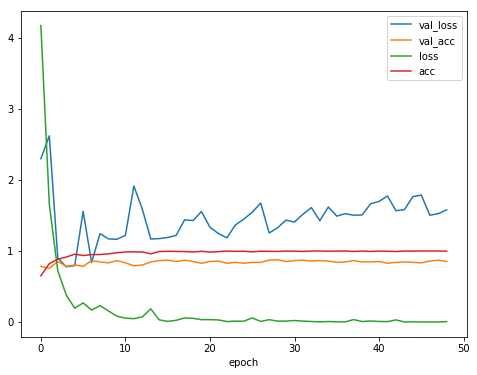

In [17]:
# Load training history to file
with open('history-top.json','r') as f:
    h = json.load(f)

plt.figure(figsize=(8,6))
for k,v in h.items():
    plt.plot(v,label=k)
plt.legend()
plt.xlabel('epoch')

print('{:0.2f}% mean accuracy in the final {} epochs.'.format(np.mean(h['val_acc'][-patience:])*100,patience))

## Let's stack the top layer on top of MobileNet to make a real-time predictor

In [18]:
model_stacked = Model(inputs=model_bottleneck.input, outputs=model_top(model_bottleneck.output))
model_stacked.summary()
model_stacked.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 128, 128, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 64, 64, 32)        864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 64, 64, 32)        128       
_________________________________________________________________
conv1_relu (Activation)      (None, 64, 64, 32)        0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 64, 64, 32)        288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 64, 64, 32)        128       
_________________________________________________________________
conv_dw_1_relu (Activation)  (None, 64, 64, 32)        0         
__________

{'sandwich': 0, 'sushi': 1}


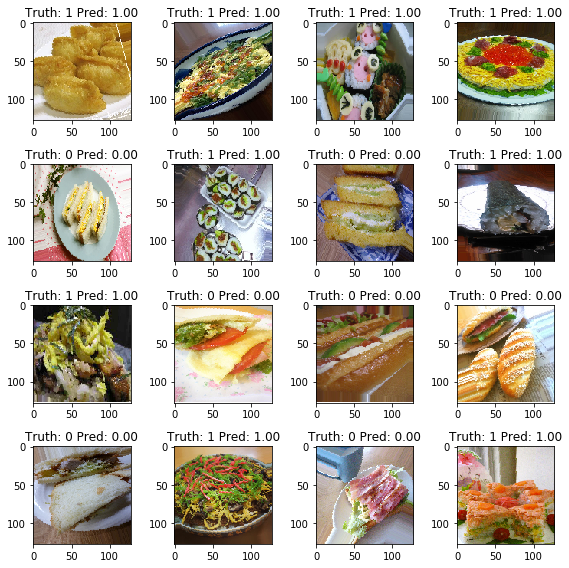

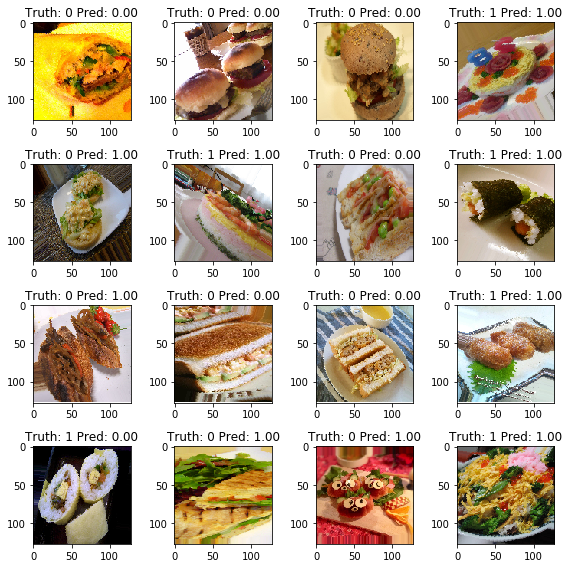

In [19]:
print(test_generator.class_indices)

images, labels = test_generator[0]
predictions = model_stacked.predict(images)

for ix,(im,l,p) in enumerate(zip(images,labels,predictions.flatten())):
    if ix%16 == 0:
        plt.figure(figsize=(8,8))
    plt.subplot(4,4,ix%16+1)
    plt.imshow(im)
    plt.title('Truth: {:0.0f} Pred: {:0.2f}'.format(l,p))
    if (ix+1)%16 == 0:
        plt.tight_layout()

## ROC cuve for the stacked model

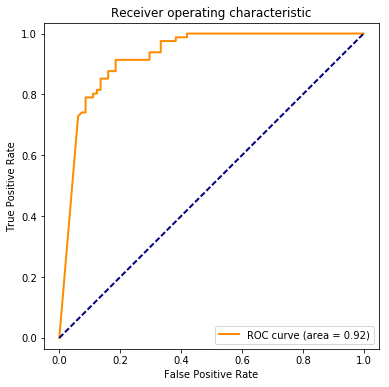

In [20]:
plot_roc_curve(model_stacked, test_generator)

## Using t-SNE to visualise dense layer weights

In [21]:
model_intermediate_fn = K.function([model_top.get_input_at(0)], outputs=[model_top.layers[1].get_output_at(0)])

In [22]:
weights = model_intermediate_fn([test_bottleneck])[0]

In [23]:
random_seed = 0
tsne = TSNE(n_components=2, random_state=random_seed, verbose=1)
transformed_weights = tsne.fit_transform(weights)

[t-SNE] Computing pairwise distances...
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Computed conditional probabilities for sample 162 / 162
[t-SNE] Mean sigma: 39.034093
[t-SNE] KL divergence after 100 iterations with early exaggeration: 2.133723
[t-SNE] Error after 325 iterations: 2.133723


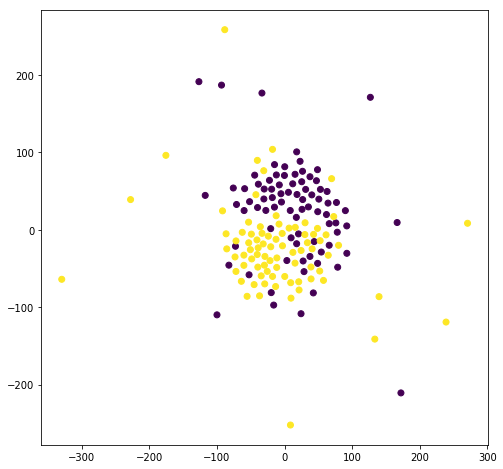

In [24]:
plt.figure(figsize=(8, 8))
plt.scatter(x = transformed_weights[:,0], y=transformed_weights[:,1], c=test_labels)
plt.show()